# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

In [1]:
# import libraries
from pyspark.sql import SparkSession
from pyspark.sql.types import StringType
from pyspark.sql.types import IntegerType
from pyspark.sql import functions as F
from pyspark.sql.functions import isnan, count,lit, when, col, desc, udf, col, sort_array, asc, avg, lag
from pyspark.sql.window import Window
from pyspark.sql.functions import sum as Fsum

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import time
%matplotlib inline

In [2]:
# create a Spark session
spark = SparkSession \
    .builder \
    .appName('Wrangling Data') \
    .getOrCreate()

# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

In [59]:
path = 'mini_sparkify_event_data.json'
df = spark.read.json(path)

In [46]:
df.head()

Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30')

In [47]:
df.count()

286500

# Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

In [32]:
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [33]:
df.count()

286500

#### Explore Nan Values

In [34]:
df.select([F.count(F.when(F.isnull(x), x)).alias(x) for x in df.columns]).toPandas().transpose()

,0
artist,58392
auth,0
firstName,8346
gender,8346
itemInSession,0
lastName,8346
length,58392
level,0
location,8346
method,0


In [35]:
df.groupby('userId').count().sort('userId').show(5)

+------+-----+
|userId|count|
+------+-----+
|      | 8346|
|    10|  795|
|   100| 3214|
|100001|  187|
|100002|  218|
+------+-----+
only showing top 5 rows



As one can see from the table above there are 8346 entries from userId **' '**, ant this correlates with amount of Nan values in several rows in df. So remove it!

In [36]:
df = df.filter(df.userId != '')

Check the Nans and userId table:

In [37]:
df.select([F.count(F.when(F.isnull(x), x)).alias(x) for x in df.columns]).toPandas().transpose()

,0
artist,50046
auth,0
firstName,0
gender,0
itemInSession,0
lastName,0
length,50046
level,0
location,0
method,0


In [38]:
df.groupby('userId').count().sort('userId').show(5)

+------+-----+
|userId|count|
+------+-----+
|    10|  795|
|   100| 3214|
|100001|  187|
|100002|  218|
|100003|   78|
+------+-----+
only showing top 5 rows



#### Adjust timestamps

In [39]:
df.select('ts','registration').show(5)

+-------------+-------------+
|           ts| registration|
+-------------+-------------+
|1538352117000|1538173362000|
|1538352180000|1538331630000|
|1538352394000|1538173362000|
|1538352416000|1538331630000|
|1538352676000|1538173362000|
+-------------+-------------+
only showing top 5 rows



Timestamps have three unnecessary zeros in the end, so they should be removed

In [40]:
ts_new = udf(lambda x: x / 1000)

df = df.withColumn('new_ts', ts_new('ts')).drop('ts')
df = df.withColumn('new_reg', ts_new('registration')).drop('registration')

In [41]:
df.select('new_ts','new_reg').show(5)

+-------------+-------------+
|       new_ts|      new_reg|
+-------------+-------------+
|1.538352117E9|1.538173362E9|
| 1.53835218E9| 1.53833163E9|
|1.538352394E9|1.538173362E9|
|1.538352416E9| 1.53833163E9|
|1.538352676E9|1.538173362E9|
+-------------+-------------+
only showing top 5 rows



#### Calculate time between actions

In order to perform feature engineering on timestamps and find out how frequent each user interracted with Sparkify the time difference between consecutive actions was calculated for each user

The code below was adopted from:
https://www.arundhaj.com/blog/calculate-difference-with-previous-row-in-pyspark.html


In [42]:
my_window = Window.partitionBy('userId').orderBy('new_ts')

In [43]:
df = df.withColumn('prev', lag(df.new_ts).over(my_window))
df = df.withColumn('diff_dates', F.when(F.isnull(df.new_ts - df.prev), 0)
                      .otherwise(df.new_ts - df.prev))

In [44]:
df.select('userId','new_ts','prev','diff_dates').show()

+------+-------------+-------------+----------+
|userId|       new_ts|         prev|diff_dates|
+------+-------------+-------------+----------+
|100010|1.539003534E9|         null|       0.0|
|100010|1.539003736E9|1.539003534E9|     202.0|
|100010|1.539003932E9|1.539003736E9|     196.0|
|100010|1.539003933E9|1.539003932E9|       1.0|
|100010|1.539004195E9|1.539003933E9|     262.0|
|100010|1.539004511E9|1.539004195E9|     316.0|
|100010|1.539004694E9|1.539004511E9|     183.0|
|100010|1.539004918E9|1.539004694E9|     224.0|
|100010|1.539004961E9|1.539004918E9|      43.0|
|100010|1.539005157E9|1.539004961E9|     196.0|
|100010|1.539005299E9|1.539005157E9|     142.0|
|100010|1.539005548E9|1.539005299E9|     249.0|
|100010|1.539005571E9|1.539005548E9|      23.0|
|100010|1.539005601E9|1.539005571E9|      30.0|
|100010|  1.5390056E9|1.539005601E9|      -1.0|
|100010|1.539005762E9|  1.5390056E9|     162.0|
|100010|1.539006085E9|1.539005762E9|     323.0|
|100010|1.539006103E9|1.539006085E9|    

In [45]:
df_pandas = df.toPandas()

#### Associate final state of df with SQL Table "df_table"

In [46]:
df.createOrReplaceTempView("df_table")

#### Get Statistics of the users and their subscription to the service

In [47]:
number_unique_users = spark.sql('''
    SELECT count(DISTINCT userID) as all_users
    FROM df_table
    ''').collect()[0]['all_users']

number_users_canceled = spark.sql('''
    SELECT count(DISTINCT userId) as cancelled
    FROM df_table
    WHERE page = 'Cancellation Confirmation'
    ''').collect()[0]['cancelled']


print('Number of unique users is {}'.format(number_unique_users))
print('Number of unique users cancelled the subscription is {}'.format(number_users_canceled))

Number of unique users is 225
Number of unique users cancelled the subscription is 52


#### Start an aggregated dataframe

##### Distinct Users, amount of songs listened and Churn columns

In [48]:
df_features = spark.sql('''
    SELECT userid, COUNT(userID) as number_songs
    FROM df_table
    WHERE page = 'NextSong'
    GROUP BY userID''')

df_users_cancelled = spark.sql('''
    SELECT DISTINCT userid as user_canc
    FROM df_table
    WHERE page = 'Cancellation Confirmation'
    ''').withColumn('Churn',lit(1))

df_features = df_features.join(df_users_cancelled,df_users_cancelled.user_canc == df_features.userid, how = 'left')
df_features = df_features.fillna(0, subset=['Churn']).select('userid','Churn','number_songs')

df_features.createOrReplaceTempView("df_features_table")

In [49]:
df_features.show()

+------+-----+------------+
|userid|Churn|number_songs|
+------+-----+------------+
|100010|    0|         275|
|200002|    0|         387|
|   125|    1|           8|
|   124|    0|        4079|
|    51|    1|        2111|
|     7|    0|         150|
|    15|    0|        1914|
|    54|    1|        2841|
|   155|    0|         820|
|100014|    1|         257|
|   132|    0|        1928|
|   154|    0|          84|
|   101|    1|        1797|
|    11|    0|         647|
|   138|    0|        2070|
|300017|    0|        3632|
|100021|    1|         230|
|    29|    1|        3028|
|    69|    0|        1125|
|   112|    0|         215|
+------+-----+------------+
only showing top 20 rows



# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

##### Add gender column

In [50]:
df_features = spark.sql('''
    SELECT df_features_table.*, table_gender.gender
    FROM (
        SELECT DISTINCT userid, gender
        FROM df_table ) as table_gender
    LEFT JOIN df_features_table
    ON table_gender.userid = df_features_table.userid
''')

##### Add a column that shows the time period since registration

In [51]:
reg_len = spark.sql('''
    SELECT userid, max(new_ts)-max(new_reg) as reg_length
    FROM df_table
    GROUP BY userid
''')

df_features = df_features.join(reg_len, reg_len.userid == df_features.userid, how = 'left').drop(reg_len.userid)

##### Add information about interactions with the Sparkify app ("page" column investigation)

Get to know the "page" column entries

In [52]:
spark.sql('''
    SELECT page, count(page) as page_stat
    FROM df_table
    GROUP BY page
    ORDER BY page_stat DESC
''').show(50)

+--------------------+---------+
|                page|page_stat|
+--------------------+---------+
|            NextSong|   228108|
|           Thumbs Up|    12551|
|                Home|    10082|
|     Add to Playlist|     6526|
|          Add Friend|     4277|
|         Roll Advert|     3933|
|              Logout|     3226|
|         Thumbs Down|     2546|
|           Downgrade|     2055|
|            Settings|     1514|
|                Help|     1454|
|             Upgrade|      499|
|               About|      495|
|       Save Settings|      310|
|               Error|      252|
|      Submit Upgrade|      159|
|    Submit Downgrade|       63|
|              Cancel|       52|
|Cancellation Conf...|       52|
+--------------------+---------+



In [53]:
page_values = spark.sql('''
    SELECT DISTINCT page
    FROM df_table
''').collect()

page_val = []

for i in page_values:
    page_val.append(i['page'])

In [54]:
for i in range(0,len(page_val)):
    col_name = 'page_'+page_val[i].replace(' ','_')
    
    temp = spark.sql('''
            SELECT userid as user_temp, count(userid) as {}
            FROM df_table
            WHERE page = '{}'
            GROUP BY userid
        '''.format(col_name,page_val[i]))
    
    df_features = df_features.join(temp, temp.user_temp == df_features.userid, how = 'left').drop(temp.user_temp)
    df_features = df_features.fillna(0, subset=[col_name])
    df_features = df_features.withColumn('p_'+page_val[i].replace(' ','_'), F.expr("{} / number_songs".format(col_name))).drop(col_name)
    

In [55]:
df_features.take(2)

[Row(userid='100010', Churn=0, number_songs=275, gender='F', reg_length=4807612.0, p_Cancel=0.0, p_Submit_Downgrade=0.0, p_Thumbs_Down=0.01818181818181818, p_Home=0.04, p_Downgrade=0.0, p_Roll_Advert=0.1890909090909091, p_Logout=0.01818181818181818, p_Save_Settings=0.0, p_Cancellation_Confirmation=0.0, p_About=0.0036363636363636364, p_Settings=0.0, p_Add_to_Playlist=0.025454545454545455, p_Add_Friend=0.014545454545454545, p_NextSong=1.0, p_Thumbs_Up=0.06181818181818182, p_Help=0.007272727272727273, p_Upgrade=0.007272727272727273, p_Error=0.0, p_Submit_Upgrade=0.0),
 Row(userid='200002', Churn=0, number_songs=387, gender='M', reg_length=6054448.0, p_Cancel=0.0, p_Submit_Downgrade=0.0, p_Thumbs_Down=0.015503875968992248, p_Home=0.05167958656330749, p_Downgrade=0.012919896640826873, p_Roll_Advert=0.01808785529715762, p_Logout=0.012919896640826873, p_Save_Settings=0.0, p_Cancellation_Confirmation=0.0, p_About=0.007751937984496124, p_Settings=0.007751937984496124, p_Add_to_Playlist=0.020671

##### Make features from "diff_dates" column

In [56]:
diff_dates_stat = spark.sql('''
    SELECT userid, max(diff_dates) as diff_dates_max, mean(diff_dates) as diff_dates_mean
    FROM df_table
    GROUP BY userid
''')

diff_dates_sessions_month = spark.sql('''
    SELECT userid, count(diff_dates) as diff_dates_session_week
    FROM df_table
    WHERE diff_dates > 600000
    GROUP BY userid
''')

diff_dates_sessions_day = spark.sql('''
    SELECT userid, count(diff_dates) as diff_dates_session_day
    FROM df_table
    WHERE diff_dates > 86000
    GROUP BY userid
''')


df_features = df_features.join(diff_dates_stat, diff_dates_stat.userid == df_features.userid, how = 'left').drop(diff_dates_stat.userid)
df_features = df_features.join(diff_dates_sessions_month, diff_dates_sessions_month.userid == df_features.userid, how = 'left').drop(diff_dates_sessions_month.userid)
df_features = df_features.join(diff_dates_sessions_day, diff_dates_sessions_day.userid == df_features.userid, how = 'left').drop(diff_dates_sessions_day.userid)
df_features = df_features.fillna(0, subset=['diff_dates_max','diff_dates_mean','diff_dates_session_month','diff_dates_session_day'])

##### Feature importance investigation

In [57]:
df_features_pd = df_features.toPandas()

In [58]:
df_features_pd

,userid,Churn,number_songs,gender,reg_length,p_Cancel,p_Submit_Downgrade,p_Thumbs_Down,p_Home,p_Downgrade,...,p_NextSong,p_Thumbs_Up,p_Help,p_Upgrade,p_Error,p_Submit_Upgrade,diff_dates_max,diff_dates_mean,diff_dates_session_week,diff_dates_session_day
0,100010,0,275,F,4807612.0,0.000000,0.000000,0.018182,0.040000,0.000000,...,1.0,0.061818,0.007273,0.007273,0.000000,0.000000,1356262.0,10027.343832,2.0,6
1,200002,0,387,M,6054448.0,0.000000,0.000000,0.015504,0.051680,0.012920,...,1.0,0.054264,0.005168,0.005168,0.000000,0.002584,2036578.0,8293.088608,2.0,5
2,125,1,8,M,6161779.0,0.125000,0.000000,0.000000,0.000000,0.000000,...,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,391.0,161.272727,NaN,0
3,124,0,4079,F,11366431.0,0.000000,0.000000,0.010051,0.043148,0.010051,...,1.0,0.041922,0.005639,0.000000,0.001471,0.000000,480612.0,1074.349016,NaN,17
4,51,1,2111,M,1680985.0,0.000474,0.000000,0.009948,0.035528,0.010895,...,1.0,0.047371,0.005685,0.000000,0.000474,0.000000,216435.0,553.303571,NaN,4
5,7,0,150,M,6288034.0,0.000000,0.000000,0.006667,0.066667,0.000000,...,1.0,0.046667,0.006667,0.013333,0.006667,0.000000,1415328.0,21829.557214,3.0,6
6,15,0,1914,M,4882773.0,0.000000,0.000000,0.007315,0.048589,0.014629,...,1.0,0.042320,0.004180,0.000000,0.001045,0.000000,981465.0,2077.437665,3.0,10
7,54,1,2841,F,9568946.0,0.000352,0.000352,0.010208,0.045407,0.013728,...,1.0,0.057374,0.005984,0.000352,0.000352,0.000352,233136.0,1075.844632,NaN,12
8,155,0,820,F,2035240.0,0.000000,0.000000,0.003659,0.036585,0.014634,...,1.0,0.070732,0.010976,0.002439,0.003659,0.001220,973987.0,2227.070858,1.0,4
9,100014,1,257,M,7351206.0,0.003891,0.000000,0.011673,0.027237,0.011673,...,1.0,0.066148,0.007782,0.000000,0.000000,0.000000,1678805.0,11495.203226,2.0,5


In [59]:
list_param = df_features.columns

list_param.remove('userid')
list_param.remove('Churn')
list_param.remove('gender')
list_param.remove('p_Cancel')
list_param.remove('p_Cancellation_Confirmation')
list_param.remove('p_NextSong')


/opt/conda/lib/python3.6/site-packages/matplotlib/pyplot.py:523: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


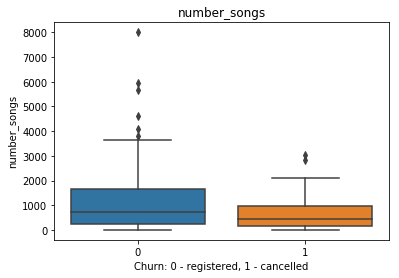

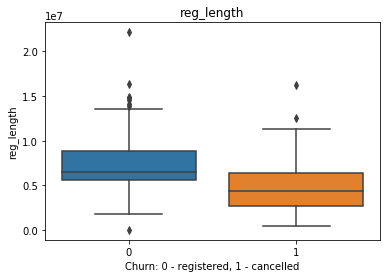

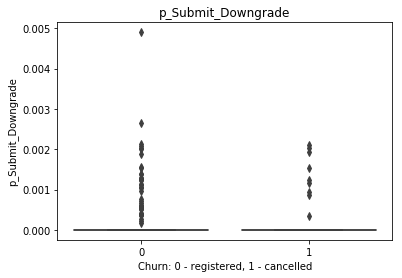

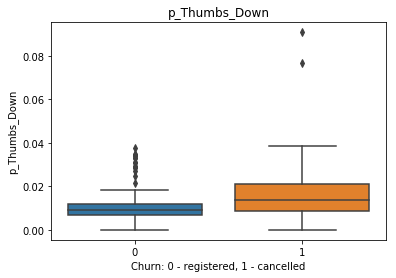

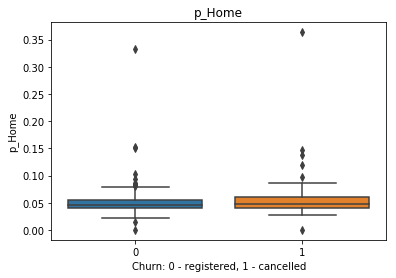

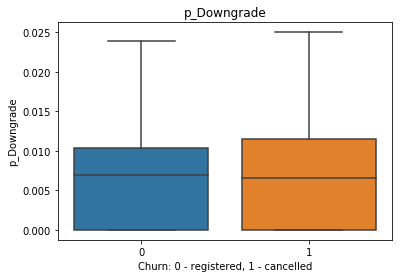

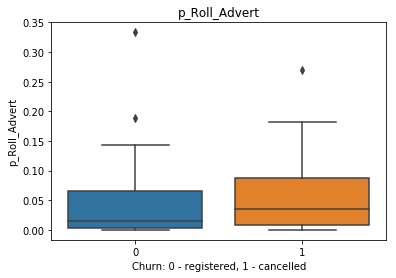

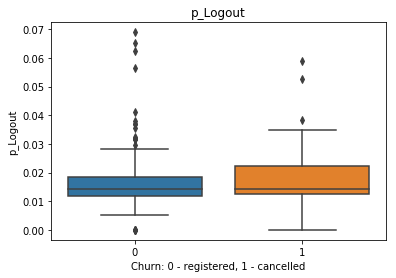

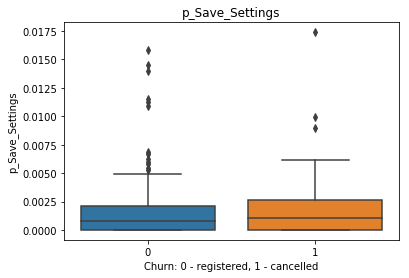

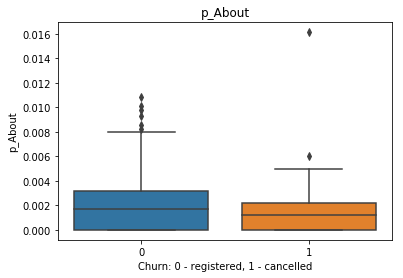

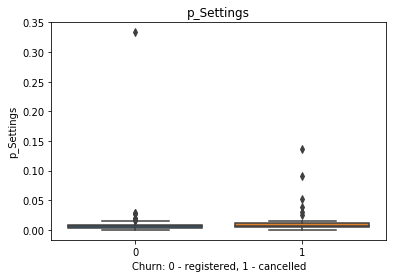

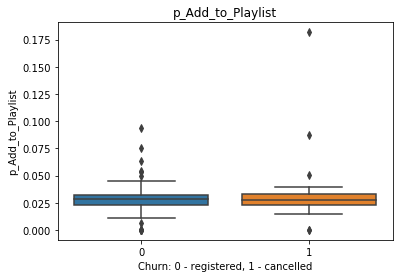

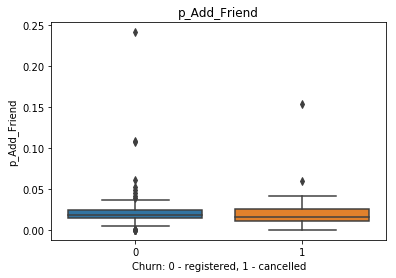

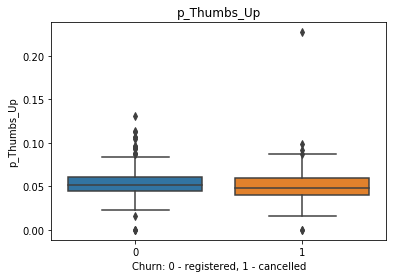

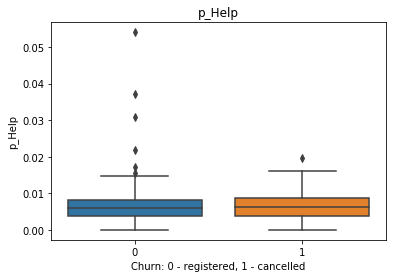

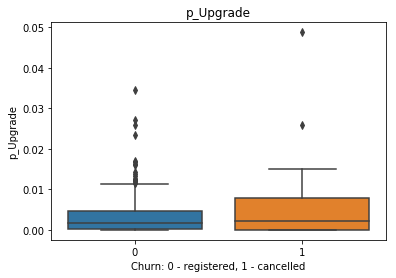

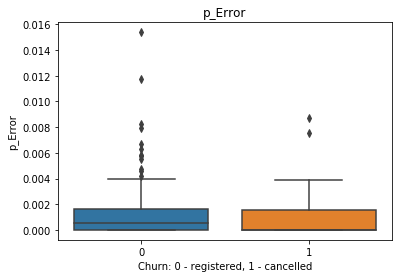

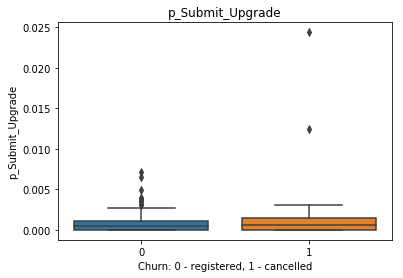

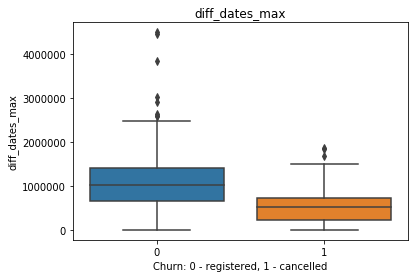

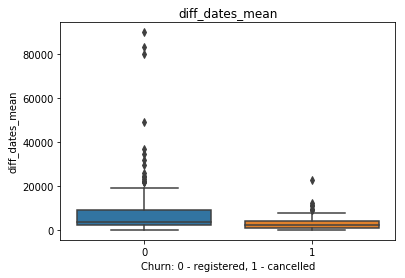

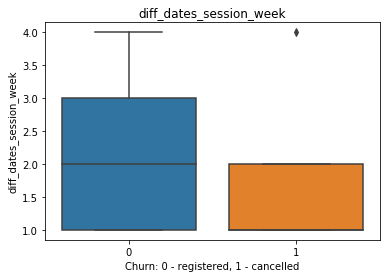

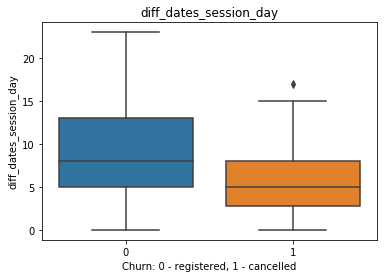

In [60]:
for i in list_param:
    fig, axes = plt.subplots()
    sns.boxplot(x = 'Churn', y = i, data = df_features_pd, ax = axes)
    axes.set_title(i)
    axes.set_ylabel(i)
    axes.set_xlabel('Churn: 0 - registered, 1 - cancelled')

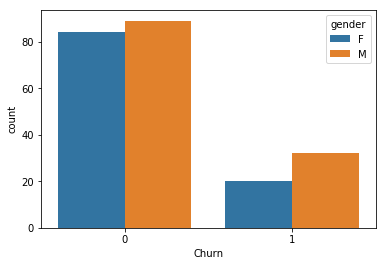

In [61]:
sns.countplot(x = 'Churn',hue = 'gender',data = df_features_pd)

Based on plots above following features found to have a possible correlation with Churn feature:
- *gender*
- *number_songs* (amount of songs user listened)
- *reg_length* (duration of time period between registration and last usage of an app)
- *p_Thumbs_Down* (ratio of amount of thumbs down given by the user relatiove to the amount of songs user listened)
- *diff_dates_max* (maximum length of time period between two consecutive app usages per user)
- *diff_dates_mean* (mean length of time period between two consecutive app usages per user)
- *diff_dates_session_week* (amount of times when user didn't use an app for at least one week)


As a result above listed features will be used in ML Model (see *"Sparkify_modeling.ipynb"*)